In [1]:
import src.paths

In [2]:
date = '2022-09-16'

In [3]:
%%time
spikes_raw = pd.read_pickle(src.paths.DATA / date / f'{date}-hpc-spikes.pkl')

CPU times: user 7.25 ms, sys: 661 ms, total: 669 ms
Wall time: 8.51 s


In [4]:
%%time
csd_raw = pd.read_pickle(src.paths.DATA / date / f'{date}-hpc-csd.pkl')

CPU times: user 3.34 ms, sys: 3.02 s, total: 3.03 s
Wall time: 29.3 s


In [5]:
start = 300 # start time in seconds
end = 1500  # end time in seconds
MAX_THETA = 15 # band max in Hz
MIN_THETA = 2  # band min in Hz

In [6]:
spikes = spikes_raw.loc[start:end - 1 / 250, 160:163]
csd = csd_raw.loc[start:end - 1 / 1250, 40]

In [7]:
q = 5
Fs = range(MIN_THETA, MAX_THETA)

In [32]:
def frequency_comb(x, freqs, q=5):
    l = []
    for freq in freqs:
        b, a = scipy.signal.iirnotch(w0=freq, Q=q, fs=1250)
        y = x - scipy.signal.filtfilt(b, a, x, axis=0)
        l.append(y)
    return np.array(l).T

In [105]:
x = csd.values * 0.001 # [A/m^3 -> uA / mm^3]

In [107]:
bands = pd.Series(Fs, name='band')
theta = frequency_comb(x, Fs, q=5)
theta = {band: y for band, y in zip(bands, theta.T)}
theta = pd.DataFrame(theta, index=csd.index, columns=bands)

In [108]:
hilbert = scipy.signal.hilbert(theta)
phase = np.angle(hilbert)
phase = pd.DataFrame(phase, index=theta.index, columns=theta.columns)

In [110]:
s = (phase / np.pi + 1) / 2

In [157]:
thresholds = [-0.5, -0.55, -0.6, -0.65, -0.7, -0.75, -0.8, -0.85, -0.9, -0.95, -0.99, -0.995, -0.999]
out = {}
for thresh in thresholds:
    cycle = (s.diff(axis=0) < thresh).cumsum(axis=0)
    ncycles = cycle.iloc[-1]
    out[thresh] = ncycles
ncycles = pd.DataFrame(out, columns=pd.Series(thresholds, name='thresholds'))

In [158]:
ncycles

thresholds,-0.500,-0.550,-0.600,-0.650,-0.700,-0.750,-0.800,-0.850,-0.900,-0.950,-0.990,-0.995,-0.999
band,,,,,,,,,,,,,
2,5863,5835,5806,5780,5750,5708,5652,5556,5369,4823,2178,1006,57
3,2674,2669,2663,2660,2655,2643,2631,2614,2576,2475,1761,1089,95
4,3261,3256,3247,3239,3232,3220,3201,3175,3102,2961,1861,1015,62
5,3522,3514,3502,3493,3481,3465,3444,3399,3343,3181,2008,1134,108
6,3905,3889,3872,3853,3841,3827,3800,3762,3703,3535,2421,1515,142
7,4254,4240,4227,4216,4197,4181,4150,4114,4056,3852,2514,1422,119
8,4612,4596,4571,4563,4546,4523,4493,4450,4375,4137,2499,1279,76
9,5186,5165,5146,5127,5110,5088,5050,4994,4867,4567,2444,1109,64
10,5511,5483,5460,5437,5415,5391,5360,5304,5191,4842,2533,1061,51


In [159]:
plt.figure(figsize=(8, 6));

<Figure size 800x600 with 0 Axes>

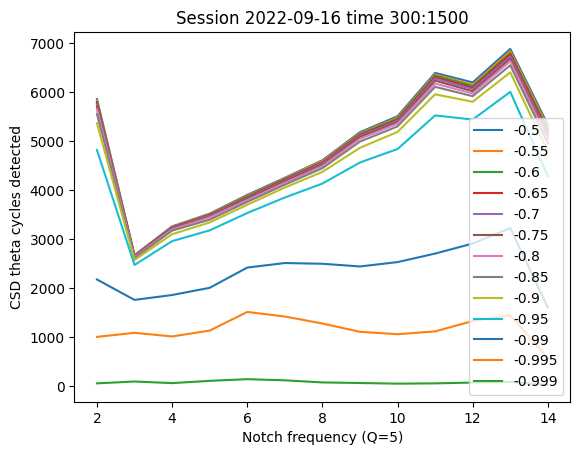

In [161]:
for thresh in ncycles.columns:
    sns.lineplot(x=ncycles.index, y=ncycles[thresh], label=thresh)
plt.legend();
plt.title(f'Session {date} time {start}:{end}')
plt.xlabel('Notch frequency (Q=5)')
plt.ylabel('CSD theta cycles detected')
plt.savefig(f'{date}-time-{start}:{end}-theta-ncycles.png', dpi=300)
plt.show()